In [22]:
import os
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization, Lambda
import sys
import random
seed = 22
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import LogNorm
from scipy.integrate import quad
import tensorflow.keras.backend as K


from scipy.special import gamma
from scipy.special import gamma
from tensorflow.keras.models import Model
from sklearn.utils import resample
from tqdm.notebook import tqdm

#--matplotlib
import matplotlib
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
matplotlib.rc('text', usetex = True)
from matplotlib import pyplot as py
from matplotlib.lines import Line2D

from IPython import display

In [2]:
train_images=np.zeros((1000,28,28))
for i in range(train_images.shape[0]):
    #events=np.random.randn(1,2)
    cov=np.array([[1,0.9],[0.9,1]])
    event=np.random.multivariate_normal([0,0], cov, 1)
    
    train_images[i]=np.histogram2d(event[:,0],event[:,1],bins=(28,28),range=((-5,5),(-5,5)))[0]

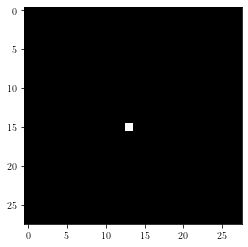

In [3]:
py.imshow(train_images[0], cmap='gray')

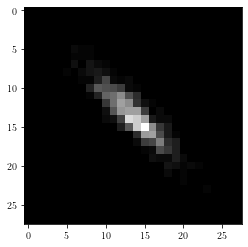

In [4]:
py.imshow(np.sum(train_images,axis=0), cmap='gray')

In [5]:
#BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [6]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 5) / 5  # Normalize the images to [-1, 1]

In [7]:
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(BATCH_SIZE)

In [65]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

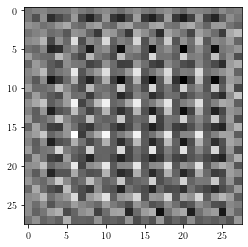

In [66]:
generator = make_generator_model()
noise = tf.random.normal([1000, 100])
generated_image = generator(noise, training=False)
py.imshow(np.sum(generated_image,axis=0)[:, :, 0], cmap='gray')

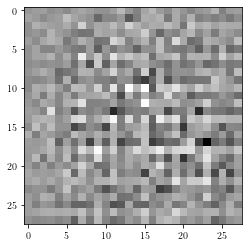

In [67]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
py.imshow(generated_image[0,:, :, 0], cmap='gray')

In [68]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model


In [69]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00039713]], shape=(1, 1), dtype=float32)


In [70]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [71]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [72]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    #print(float(gen_loss),type(gen_loss))
    GL.append(float(gen_loss))
    DL.append(float(disc_loss)/2)
    

In [73]:
def train(dataset, epochs,GL,DL):
    for epoch in  range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
GL=[]; DL=[]

In [75]:
for i in range(1000):
    train(train_dataset, EPOCHS,GL,DL)
    
    nrows,ncols=1,2
    fig = py.figure(figsize=(ncols*5,nrows*4))    
    
    ax=py.subplot(nrows,ncols,1)
    I=np.arange(len(GL))
    ax.plot(I,GL,label='GL')
    ax.plot(I,np.array(DL),label='DL')
    ax.legend()
    
    ax=py.subplot(nrows,ncols,2)
    noise = tf.random.normal([1000, noise_dim])
    generated_images = generator(noise, training=False)
    ax.imshow(np.sum(generated_images,axis=0)[:,:,0], cmap='gray')
    py.show()
    
    display.display(py.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0)
    py.close()

KeyboardInterrupt: 

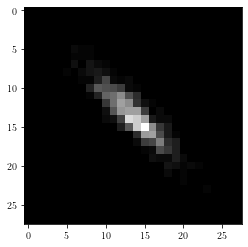

In [19]:
py.imshow(np.sum(train_images,axis=0)[:,:,0], cmap='gray')